<a href="https://colab.research.google.com/github/ipavlopoulos/modern_nlp/blob/main/ModernNLP_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModernNLP: #1
* Talk about word usage change and this recent [Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora](https://www.aclweb.org/anthology/2020.acl-main.51.pdf).
* As background, read Mikolov's [ICLR](https://research.google/pubs/pub41224/) and [NIPS](https://papers.nips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html) papers, and alingment models such as [Procrustes](https://www.aclweb.org/anthology/K18-1021.pdf) and [Compass](https://arxiv.org/abs/1906.02376).
* Whoever interested take a look [subword embeddings](https://www.aclweb.org/anthology/P16-1162.pdf). 
* Import Gensim's Word2Vec.

Adapted from:
```
John Pavlopoulos, Senior Lecturer (fixed-term) 
Stockholm University, Sweden
```

By:
```
Guilherme Dinis J., Phd Candidate
Stockholm University, Sweden
```




---



## Context

We are studying the method proposed by Gonen, et. al to measure word change usage between corpora, through their embeddings.
Their approach is based on comparing nearest neighbours - the hypothesis being that if words remain the same, their neighbors will also be the same, but if they change in usage, then so will their neighbours.

This notebooks shows this pattern for the Brown dataset - when using embeddings.

In [1]:
%%capture
from gensim.models import word2vec
from gensim import models
from gensim import corpora
import logging
import nltk
from nltk.corpus import brown
import multiprocessing as mp
from typing import List, Sequence, Mapping, Tuple, Any, Tuple
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

import collections

In [2]:
%matplotlib inline

Import NLTK and download the Brown corpus. 

In [3]:
nltk.download('brown')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
len(set(brown.words()))

56057

In [5]:
print(brown.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


In [6]:
def generate_embeddings(
    corpus: List[List[str]], num_spaces: int, vector_size: int = 100, negative: int = 5
) -> List[Any]:
    spaces = []
    # different spaces
    for i in range(num_spaces):
        space = word2vec.Word2Vec(
            corpus, vector_size=vector_size, negative=negative, seed=i, workers=mp.cpu_count()
        )
        spaces.append(space)
    return spaces

In [7]:
def word_neighbors(
  target: str, topn: int, spaces: List[word2vec.Word2Vec]
) -> Mapping[int, Sequence[Tuple[str, float]]]:
  # the neighbors
  neighbors = {}
  for i, space in enumerate(spaces):
    neighbors[i] = space.wv.most_similar(positive=[target], topn=topn)
  return neighbors

In [8]:
def create_word_frequency(words: List[str]) -> corpora.Dictionary:
    return collections.Counter(words)

In [9]:
spaces = generate_embeddings(corpus=brown.sents(), num_spaces=10)

2021-04-20 23:20:42,513 : INFO : collected 56057 word types from a corpus of 1161192 raw words and 57340 sentences
2021-04-20 23:20:42,514 : INFO : Creating a fresh vocabulary
2021-04-20 23:20:42,640 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 15173 unique words (27.067092423782935%% of original 56057, drops 40884)', 'datetime': '2021-04-20T23:20:42.640013', 'gensim': '4.0.1', 'python': '3.7.5 (default, Nov  6 2019, 22:15:04) \n[Clang 11.0.0 (clang-1100.0.33.8)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2021-04-20 23:20:42,640 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1095086 word corpus (94.30705688637194%% of original 1161192, drops 66106)', 'datetime': '2021-04-20T23:20:42.640929', 'gensim': '4.0.1', 'python': '3.7.5 (default, Nov  6 2019, 22:15:04) \n[Clang 11.0.0 (clang-1100.0.33.8)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2021-04-20 23:20:42,803 : INFO : 

In [10]:

def neighbour_overlap(v1, v2):
  """Overlap between two lists. Each element is a 2-tuple of (word, score)."""
  assert len(v1) == len(v2)
  pool = set([word for word, _ in v2])
  return len([1 for (w1, _), _ in zip(v1, v2) if w1 in pool])/len(v1)

def score(v1, v2):
  assert len(v1) == len(v2)
  pool = set([word for word, _ in v2])
  return -len([1 for (w1, _), _ in zip(v1, v2) if w1 in pool])


def vocabulary_overlap(neighbors: Mapping[int, Sequence[Tuple[str, float]]], minn: int, maxn: int) -> List[float]:
  """
  Computes the overlap between sets of neibhors.
  The number of neihbors used varies from minn to maxn.
  """
  mean_overlaps = []
  all_overlaps = {}
  for n in range(minn, maxn + 1):
    # compute similarities
    for i in range(len(neighbors)):
      for j in range(len(neighbors)):
        if i < j: 
          # compare only the top n items in the lists
          overlap = neighbour_overlap(neighbors[i][:n], neighbors[j][:n])
          all_overlaps[(i, j)] = overlap
          all_overlaps[(j, i)] = overlap
    
    overlaps = []
    for i in range(len(neighbors)):  
      ij_overlaps = []
      for j in range(len(neighbors)):
        if i != j:
          ij_overlaps.append(all_overlaps[(i, j)])
      overlaps.append(np.mean(ij_overlaps))
    mean_overlaps.append(np.mean(overlaps))
  return mean_overlaps



In [11]:
def plot_and_show_overlaps(word: str, spaces: List[Any], topn: int, minn: int, maxn: int) -> None:
    neighbors = word_neighbors(target=word, topn=topn, spaces=spaces)
    mean_overlaps = vocabulary_overlap(neighbors, minn=minn, maxn=maxn)

    # Plot the mean relative overlap of a word with its self (self-similarity), 
    # for a varying number of neighbors.
    pd.DataFrame({"self similariry": mean_overlaps}).plot();
    top10 = pd.DataFrame({i:[n[0] for n in neighbors[i][:10]] for i in neighbors})
    top10.head()



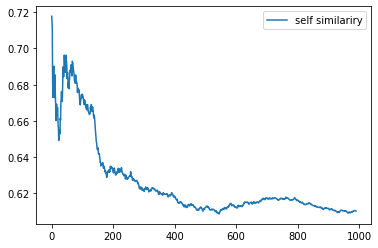

In [12]:
plot_and_show_overlaps(word="house", spaces=spaces, topn=1000, minn=10, maxn=1000)

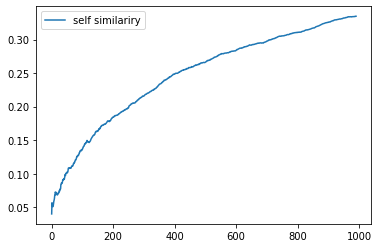

In [13]:
plot_and_show_overlaps(word="gay", spaces=spaces, topn=1000, minn=10, maxn=1000)

In [14]:
# get the mean overlap for top K NN, for a set of words
def words_nn_overlaps(words: List[str], spaces: List[Any], topn: int, minn: int, maxn: int) -> List[List[float]]:
    results = []
    for word in words:
        neighbors = word_neighbors(target=word, topn=topn, spaces=spaces)
        mean_overlaps = vocabulary_overlap(neighbors, minn=minn, maxn=maxn)
        results.append(mean_overlaps)
    return results

In [15]:
# plot the mean overlap for a set of words
def plot_words_nn_overlaps(words: List[str], words_overlaps: List[List[float]]) -> Any:
    fig, ax = plt.subplots(figsize=(12, 8))
    for word, overlaps in zip(words, words_overlaps):
        plt.plot(overlaps, label=word)
    ax.set_title("Word Overlaps")
    ax.legend()


## Comparing Frequent, Infrequent, and Middle Words

In [16]:
word_frequency = create_word_frequency(brown.words())

In [17]:
def compute_and_plot_overlaps(words: List[str], spaces: List[Any], topn: int, minn: int, maxn: int):
    overlaps = words_nn_overlaps(
        words, spaces=spaces, topn=topn, minn=minn, maxn=maxn
    )
    plot_words_nn_overlaps(words=words, words_overlaps=overlaps)

In [18]:
def get_word_counts(word_frequency: collections.Counter, n: int, mode: str, min_count: int):
    if mode == "head":
        return [(word, count) for word, count in word_frequency.most_common()[:n] if count >= min_count]
    elif mode == "tail":
        results = []
        for word, count in reversed(word_frequency.most_common()):
            if count >= min_count:
                results.append((word, count))
            if len(results) >= n:
                break
        return results
    elif mode == "middle":
        results = []
        # filter min count first
        most_common = [(word, count) for word, count in word_frequency.most_common() if count >= min_count]
        unique_frequency = sorted(set([count for _, count in most_common]))
        mid_value_index = int(len(unique_frequency) * 0.5)
        start_index = int(mid_value_index - n / 2)
        mid_values = [unique_frequency[i] for i in range(start_index, start_index + n)]
        # find words with mid_values count
        for mid_value in mid_values:
            for i in range(len(most_common)):
                word, count = most_common[i]
                if count == mid_value:
                    results.append((word, count))
                    break
        return results


### Frequent Terms

In [19]:
most_frequent_words_count = get_word_counts(word_frequency, n=10, mode="head", min_count=10)
most_frequent_words = [word for word, _ in most_frequent_words_count]

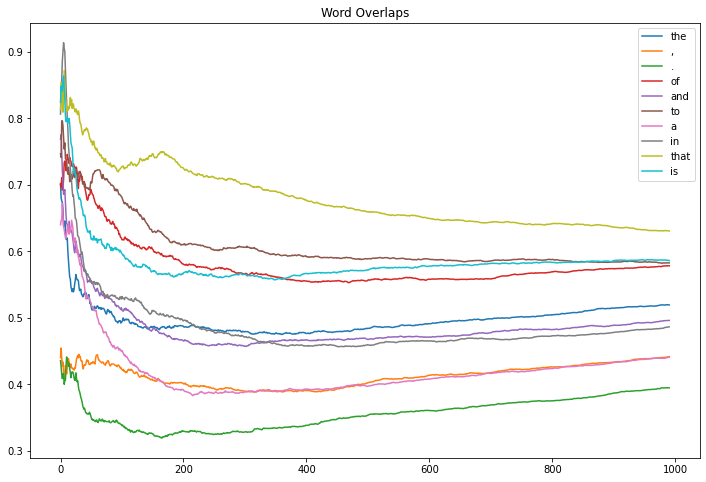

In [20]:
compute_and_plot_overlaps(most_frequent_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

### Infrequent Terms

In [21]:
least_frequent_words_count = get_word_counts(word_frequency, n=10, mode="tail", min_count=10)
least_frequent_words = [word for word, _ in least_frequent_words_count]

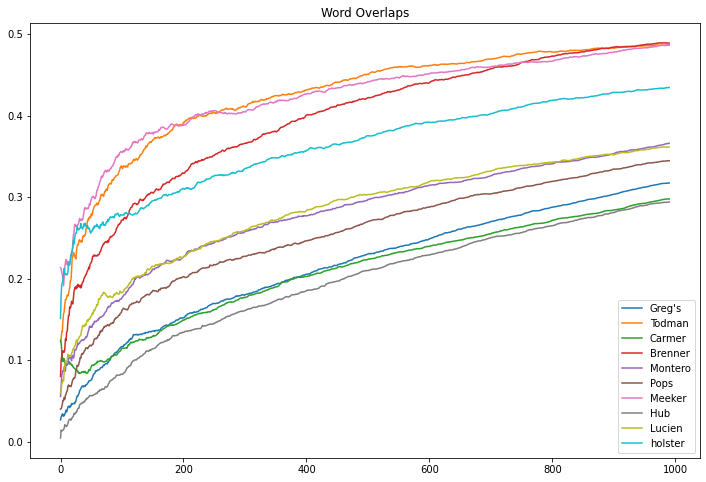

In [22]:
compute_and_plot_overlaps(least_frequent_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

### Middle Words

In [23]:
middle_words_count = get_word_counts(word_frequency, n=10, mode="middle", min_count=10)
middle_words = [word for word, _ in middle_words_count]

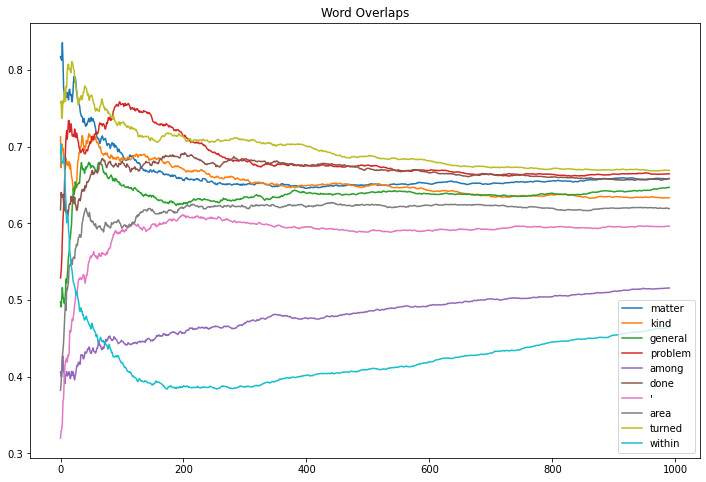

In [24]:
compute_and_plot_overlaps(middle_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

In [25]:
middle_words_count

[('matter', 306),
 ('kind', 310),
 ('general', 311),
 ('problem', 312),
 ('among', 314),
 ('done', 316),
 ("'", 317),
 ('area', 319),
 ('turned', 320),
 ('within', 321)]

Because we are comparing the same corpus here, what we would expect to observe is that the top K neighbours for infrequent terms should be the same - in fact, some words might only appear once next to two other words - (W2V ran with a limit of 1 occurence).
Since we're using embeddings, these low frequency terms will have fewer (gradient) updates - so our estimates of their consine distance to other terms should be less certain - hence, we can easily find lower overlap across embeddings.
In our plots, we're using words that appear at least 10 times.


The paper notes that the more neighbours used, the more "stable" the similarity is between neighbours.
However, there is another factor at play here: term frequency.

Very frequent words are showing high overlap at low values of K, and these terms include supporting words (e.g. from, the) - an overlap that decreases as K increases - note that "." and the "`" chars are an exception, having more diverse terms as neighbours.
Before decreasing, the overlap also increases slightly for standard words - possibly due to other high frequency words appearing in the comparative set.

The variacne in overlap is reflected more for mid frequency terms. 
When comparing them on the same corpus, the overlap for these terms can be a hit or miss since they can have a bigger pool of possible NN - and which ones end up closest will depend on other factors (e.g. network initialization).

The infrequent words, on the other hand, show the opposite behavior - their rarity means that they can appear next to diverse terms, and at a low count.
So in terms of pair frequency, there can be a few terms considered NN, and with a small frequency, i.e. [(a, b), 1].
In terms of data for learning representations, we can expect higher changes in the position of words in the embeddings space across trainings.




The question is: for corpora where usage has actually changed, what would we observe?

## Comparing Different Corpora

In [26]:
from nltk.corpus import comtrans

In [27]:
len(comtrans.words())

1978268

In [28]:
comtrans_word_frequency = create_word_frequency(comtrans.words())

In [29]:
cmrw = set(comtrans.words())

In [30]:
len(cmrw)

55861

In [31]:

for token, count in middle_words_count:
    print(f"{token}({count}) is present in Reviews: {token in cmrw}, count - {comtrans_word_frequency[token]}")
    

matter(306) is present in Reviews: True, count - 375
kind(310) is present in Reviews: True, count - 182
general(311) is present in Reviews: True, count - 190
problem(312) is present in Reviews: True, count - 385
among(314) is present in Reviews: True, count - 93
done(316) is present in Reviews: True, count - 310
'(317) is present in Reviews: True, count - 2622
area(319) is present in Reviews: True, count - 399
turned(320) is present in Reviews: True, count - 18
within(321) is present in Reviews: True, count - 533


In [32]:
comtrans_spaces = generate_embeddings(corpus=comtrans.sents(), num_spaces=1)

2021-04-20 23:25:33,068 : INFO : collecting all words and their counts
2021-04-20 23:25:33,148 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-20 23:25:33,938 : INFO : PROGRESS: at sentence #10000, processed 197419 words, keeping 17580 word types
2021-04-20 23:25:35,810 : INFO : PROGRESS: at sentence #20000, processed 398368 words, keeping 26992 word types
2021-04-20 23:25:36,960 : INFO : PROGRESS: at sentence #30000, processed 599981 words, keeping 34143 word types
2021-04-20 23:25:37,845 : INFO : PROGRESS: at sentence #40000, processed 793831 words, keeping 37714 word types
2021-04-20 23:25:38,669 : INFO : PROGRESS: at sentence #50000, processed 986006 words, keeping 38457 word types
2021-04-20 23:25:39,434 : INFO : PROGRESS: at sentence #60000, processed 1178130 words, keeping 39291 word types
2021-04-20 23:25:40,245 : INFO : PROGRESS: at sentence #70000, processed 1372358 words, keeping 44934 word types
2021-04-20 23:25:41,764 : INFO : PROGRESS: a

In [33]:
# similar absolute frequency
pd.DataFrame(
    word_neighbors(target="matter", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(reason, 0.9032586812973022)","(issue, 0.9401087164878845)"
1,"(question, 0.8841646313667297)","(document, 0.9107480645179749)"
2,"(true, 0.8736647367477417)","(measure, 0.9085996747016907)"
3,"(thing, 0.8663359880447388)","(subject, 0.9031344056129456)"
4,"(problem, 0.8651478886604309)","(task, 0.8997017741203308)"
5,"(idea, 0.8637564182281494)","(idea, 0.8958173990249634)"
6,"(evidence, 0.8584648966789246)","(step, 0.8920367360115051)"
7,"(sort, 0.8557273149490356)","(problem, 0.8840535879135132)"
8,"(means, 0.845150887966156)","(approach, 0.8747645616531372)"
9,"(truth, 0.8389140367507935)","(goal, 0.8746303915977478)"


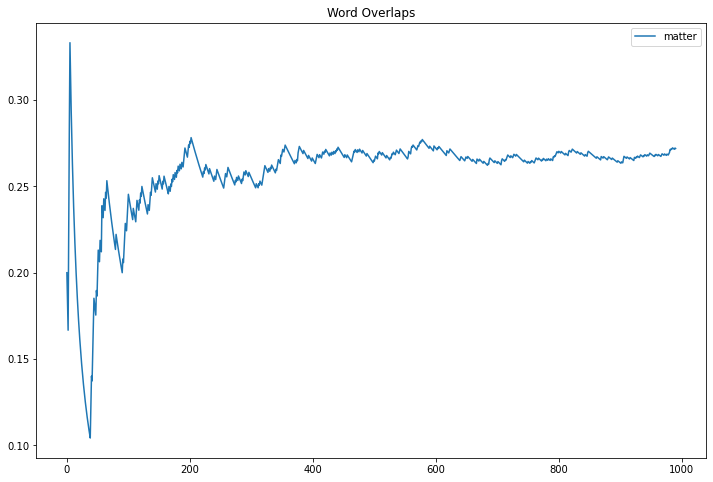

In [34]:
compute_and_plot_overlaps(["matter"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

In [35]:
# reduced absolute frequency
pd.DataFrame(
    word_neighbors(target="among", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(within, 0.808211088180542)","(including, 0.9203271269798279)"
1,"(Among, 0.8024084568023682)","(amongst, 0.9146687984466553)"
2,"(ways, 0.7878842353820801)","(involving, 0.8927068114280701)"
3,"(warts, 0.7631744742393494)","(young, 0.8865866661071777)"
4,"(counterparts, 0.7594528198242188)","(around, 0.8837758898735046)"
5,"(parts, 0.7504314184188843)","(across, 0.8741048574447632)"
6,"(skills, 0.7488998770713806)","(outside, 0.8724516034126282)"
7,"(members, 0.7445003986358643)","(diplomatic, 0.8675020933151245)"
8,"(types, 0.7370618581771851)","(disasters, 0.8673409819602966)"
9,"(myriad, 0.7343567609786987)","(containing, 0.8589285612106323)"


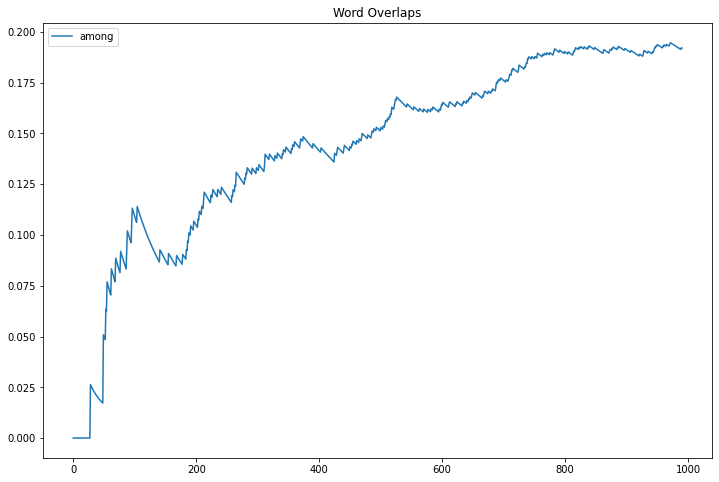

In [36]:
compute_and_plot_overlaps(["among"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

In [37]:
# increased absolute frequency
pd.DataFrame(
    word_neighbors(target="within", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(under, 0.8271967172622681)","(between, 0.9078115820884705)"
1,"(throughout, 0.820341944694519)","(under, 0.905265212059021)"
2,"(between, 0.8156911730766296)","(outside, 0.9034496545791626)"
3,"(among, 0.8082111477851868)","(concerning, 0.8876678943634033)"
4,"(With, 0.7965725064277649)","(throughout, 0.8859918713569641)"
5,"(for, 0.7736801505088806)","(across, 0.8740444779396057)"
6,"(Within, 0.7698296308517456)","(regarding, 0.8734519481658936)"
7,"(beyond, 0.7667332291603088)","(through, 0.8612239360809326)"
8,"(major, 0.7655780911445618)","(National, 0.8608638644218445)"
9,"(outlines, 0.7627107501029968)","(behind, 0.8567504286766052)"


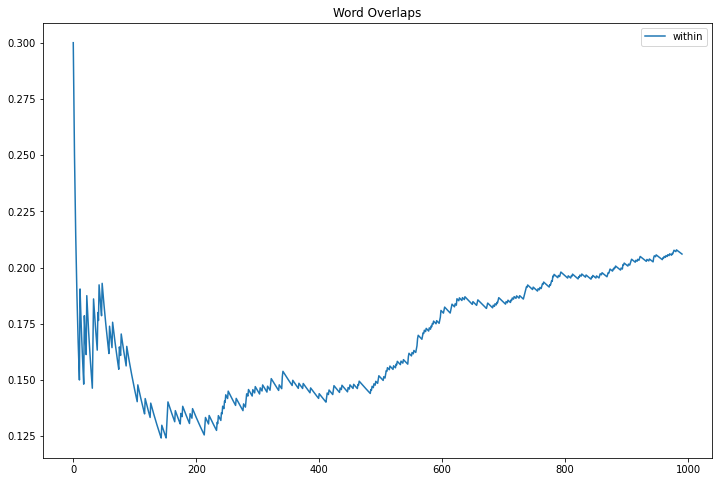

In [38]:
compute_and_plot_overlaps(["within"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

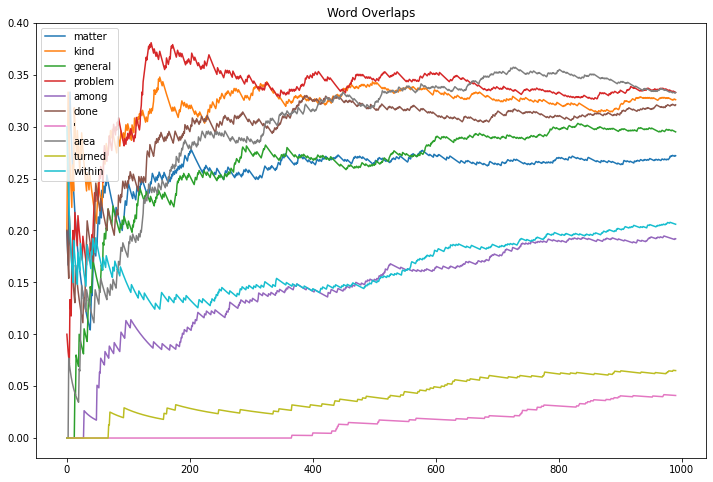

In [39]:
compute_and_plot_overlaps(middle_words, spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

We can see how relative term frequency plays a role here as well.

For every scenario - similar/increased/decreased word absolute frequency - the pattern differs at low values of K, but shows the trend of going from low overlap to an increase in overlap - even for tokens with virtually no overlap at low values of K.

This indicates that increasing K simply answers the question - how much overlap between tokens exists in the corpora?


Inspecting the NN in the three cases, we see dissimilarity. But it is difficult to judge without comparing other NN words - especially for terms with a high count of neighours having moderate frequency each in the corpus, which can have several potential candidate NN whose promximity will vary slightly (e.g. due to noise in generating the embeddings).

The differences lie at the smaller K:

  - Words infrequent in one set will have low overlap (at lower K).
  - Words moderately or highly frequent on both sets will have higher overlap (at lower K).




Determing if a word's usage is the same would, in theory from the NN principle, imply that the word would have to share the same neighbours - and the occurence of the word and its neighbours ought to be relatively the same between corpora.
But as we have seen, both rare and high frequency can be misinterpreted - the former
because of label bias and the latter for having a larger pool of "NN" in the embedding space.
It would be interesting to study how the change in the frequency use of a neighbour would affect the overlap of a
word under consideration; and how the method behaves when actual word frequencies are used instead of embeddings (i.e. counting neighbors to determine NN).

These observations raise one question:

  - For the tasks that are concerned with usage change (e.g. social science studies, as mentioned in the paper), is this definition of word usage change satisfactory - considering the change in frequency of word's neighbour can affect it's own standing in the embedding space?

In summary:

  - With this method, frequency of terms (and their neighbours) appears to have a very high impact on overlap - so usage change as defined here is a factor of neighbours and frequency.
  - Overlap might not even hold for the same words across embeddings due to randomization, and frequency of other terms in the dataset
  - At low values of K, a mid word can have too high of a candidate pool to determine their NN consistenly across embeddings from the same corpus - perhaps a more strict approach would offer stability (e.g. learn which word preceds and follows, instead of using a larger window), but it would likely bring other limitations.
  - The stability of overlap that is observed at very large K is likely due to overlap between terms in the corpus - hence not indicative of stability of the method itself.
